In [1]:
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import matplotlib.gridspec as gridspec
import pandas as pd
from config import predpath, survpath, phedefpath, phecodespath, phecatpath, trainpath, temppath, outputpath
sys.path.append(trainpath)
import survutil

In [2]:
class pheNN(nn.Module):
    def __init__(self, input_size, output_size, depth, width):
        super(pheNN, self).__init__()
        layers = []
        for i in range(depth):
            layers.append(nn.Linear(width, width))
        self.inlayer = nn.Linear(input_size, width)
        self.layers = nn.ModuleList(layers)
        self.outlayer = nn.Linear(width, output_size)

    def forward(self, x):
        x = self.inlayer(x)
        for layer in self.layers:
            x = layer(x)
            x = nn.ReLU()(x)
        x = self.outlayer(x)
        return x

    def initialize(self):
        pass

class DeepSurv(nn.Module):
    def __init__(self, input_size, output_size, depth, width):
        super(DeepSurv, self).__init__()
        layers = []
        for i in range(depth):
            layers.append(nn.Linear(width, width))

        normalization = []
        for i in range(depth):
            normalization.append(nn.BatchNorm1d(width,affine=False))
        self.inlayer = nn.Linear(input_size, width)
        self.layers = nn.ModuleList(layers)
        self.normalization = nn.ModuleList(normalization)
        self.outlayer = nn.Linear(width, output_size)
        self.initialize()

    def forward(self, x):
        x = self.inlayer(x)
        for (layer, normal) in zip(self.layers, self.normalization):
            x = layer(x)
            x = normal(x)
            x = nn.SELU()(x)
        x = self.outlayer(x)
        return x
    
    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

In [3]:
model = torch.load(predpath + "610_3model")
corrprediction=model.outlayer.weight.data.to('cpu').numpy()
model = torch.load(survpath + "610_0model")
corrsurvival=model.outlayer.weight.cpu().detach().numpy()

In [4]:
phecat = np.load(phecatpath, allow_pickle=True)[0]

In [5]:
random.seed(0)
np.random.seed(0)
X = corrprediction
tsne = TSNE()
X_tsne_prediction = tsne.fit_transform(X)
np.save("tsne_prediction.npy", X_tsne_prediction)

random.seed(0)
np.random.seed(0)
X = corrsurvival
tsne = TSNE()
X_tsne_survival = 0.8 * tsne.fit_transform(X)
np.save("tsne_survival.npy", X_tsne_survival)

In [6]:
cm1 = colormaps['tab20']
cm2 = colormaps['Dark2']
colorlist=[]
for i in range(20):
    colorlist.append(cm1(i))
colorlist.append(cm2(0))
cm = LinearSegmentedColormap.from_list('sample', colorlist, N=21)

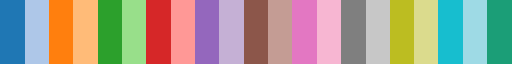

In [7]:
cm

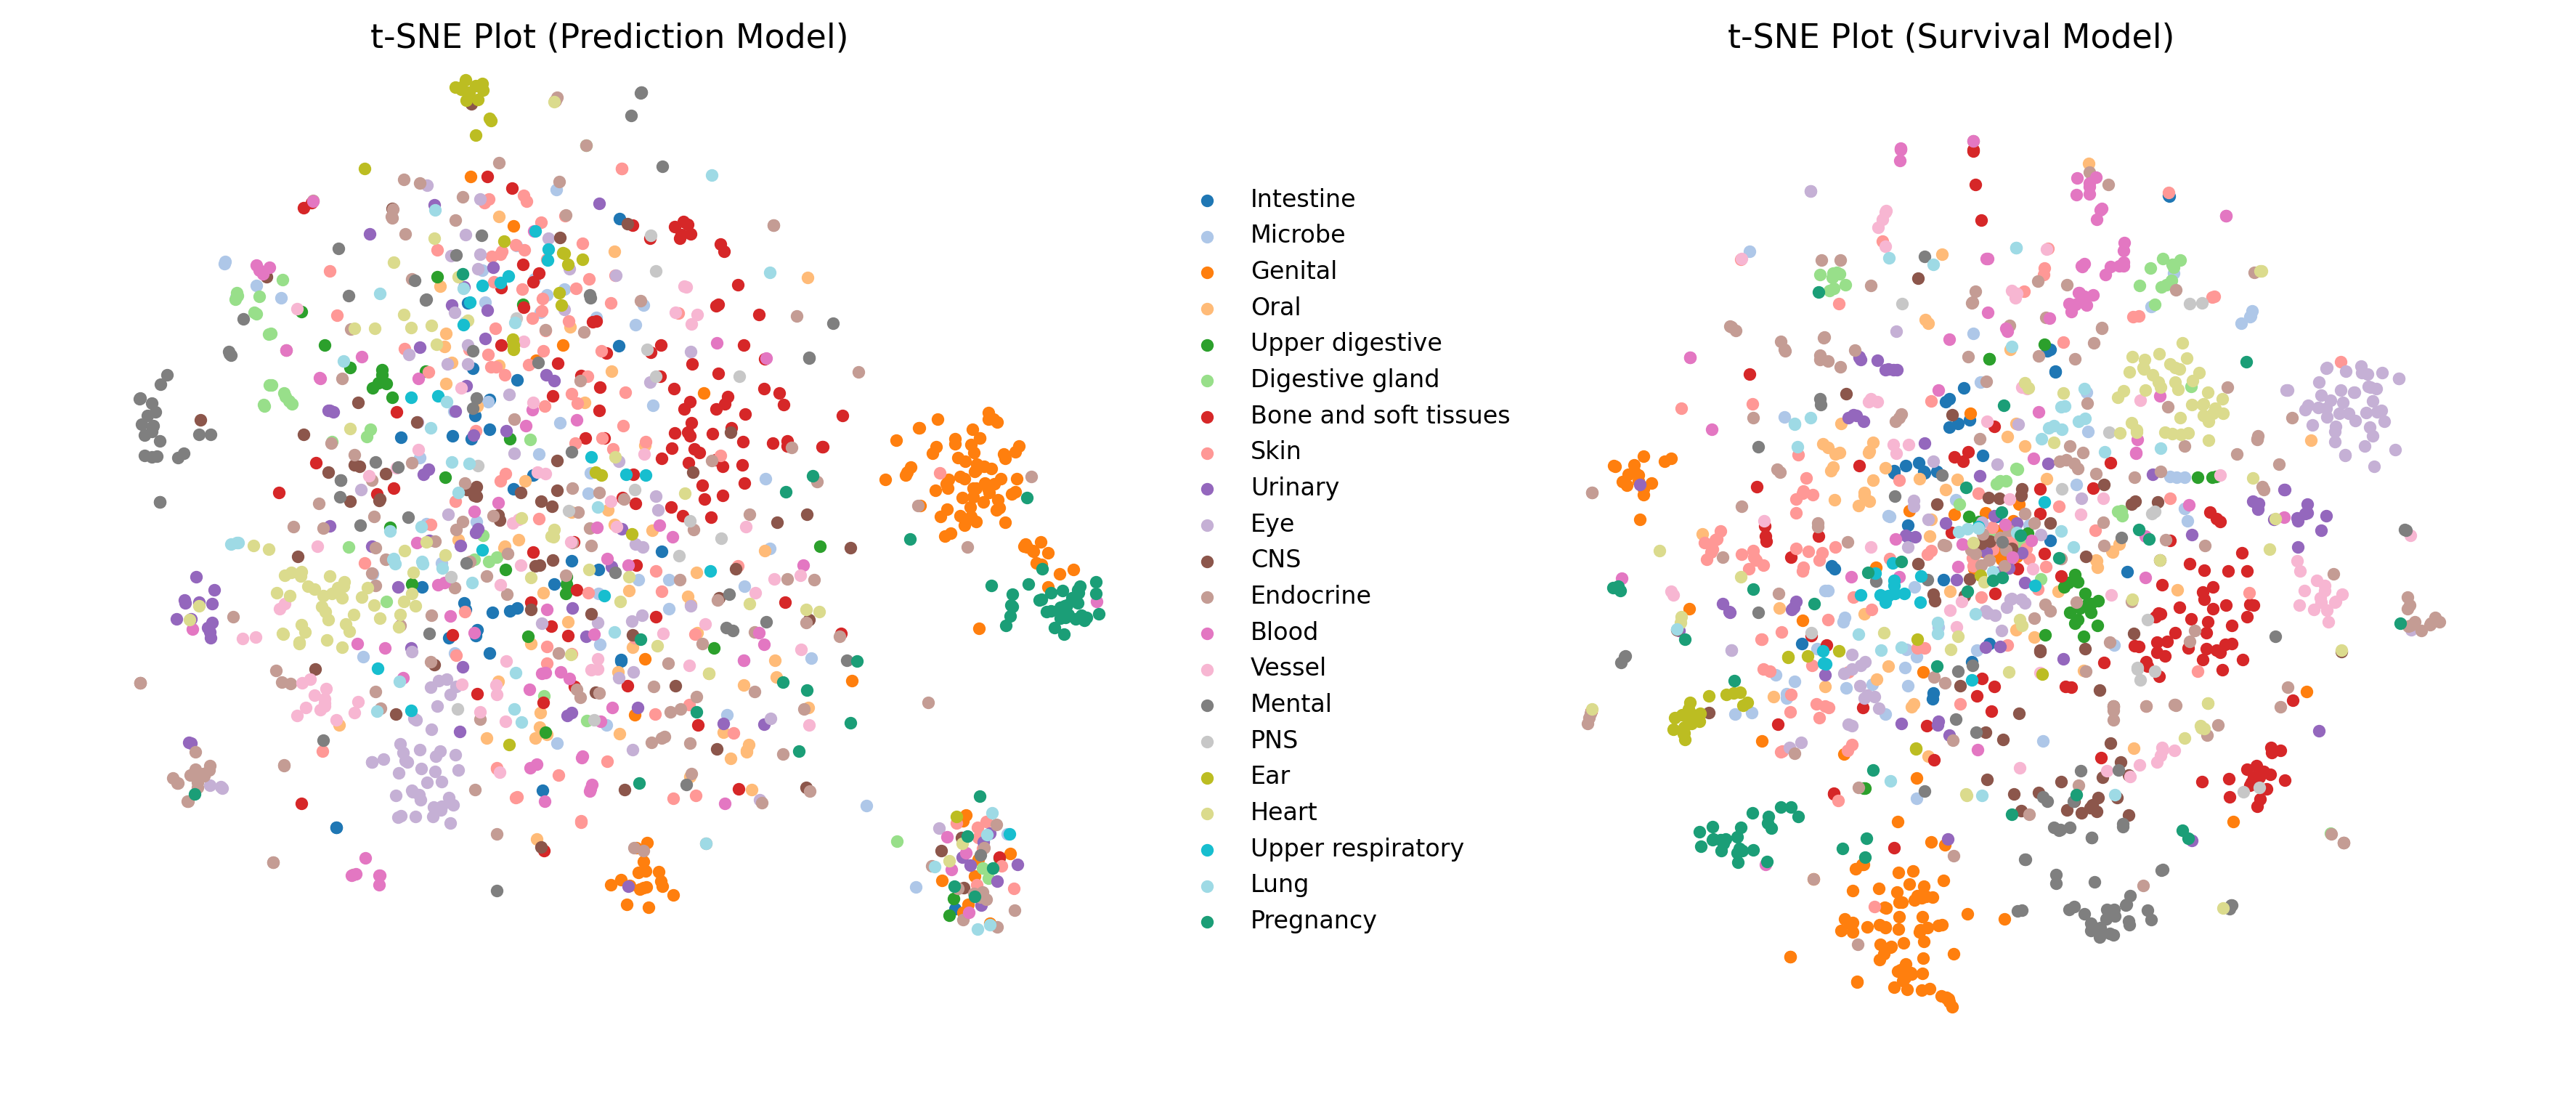

In [8]:
fig = plt.figure(figsize=(15, 6), dpi=300)
gs0 = gridspec.GridSpec(1, 4, figure=fig, wspace=-0.3, width_ratios = [0.05,0.95,1.05,0.01])
ax0 = fig.add_subplot(gs0[0, 0])
ax0.axis('off')
ax1 = fig.add_subplot(gs0[0, 1])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_prediction[v,:]
    marker='o'
    pic = ax1.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
    i+=1
handles, labels = ax1.get_legend_handles_labels()
unique_legend_dict = {}
for handle, label in zip(handles, labels):
    if label == 'Others':
        continue
    if label not in unique_legend_dict:
        unique_legend_dict[label] = handle

unique_labels = list(unique_legend_dict.keys())
unique_handles = [unique_legend_dict[label] for label in unique_labels]
title1 = 't-SNE Plot (Prediction Model)'
ax1.set_title(title1, fontsize=11)
# plot circles
ax1.axis('off')
ax1.set_aspect('equal')
ax1.set_xlim(-37,45)
ax1.set_ylim(-40,35)

ax2 = fig.add_subplot(gs0[0, 2])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_survival[v,:]
    marker='o'
    pic = ax2.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
    i+=1
title2 = 't-SNE Plot (Survival Model)'
ax2.set_title(title2, fontsize=11)
ax2.axis('off')
ax2.set_xlim(-50,40)
ax2.set_ylim(-40,40)
ax2.set_aspect('equal')
legend = ax2.legend(unique_handles, unique_labels, bbox_to_anchor=(0.13, 0.9), fontsize=8)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
title = 'sup_scatter'
ax3 = fig.add_subplot(gs0[0, 3])
ax3.axis('off')
plt.savefig(outputpath + title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()

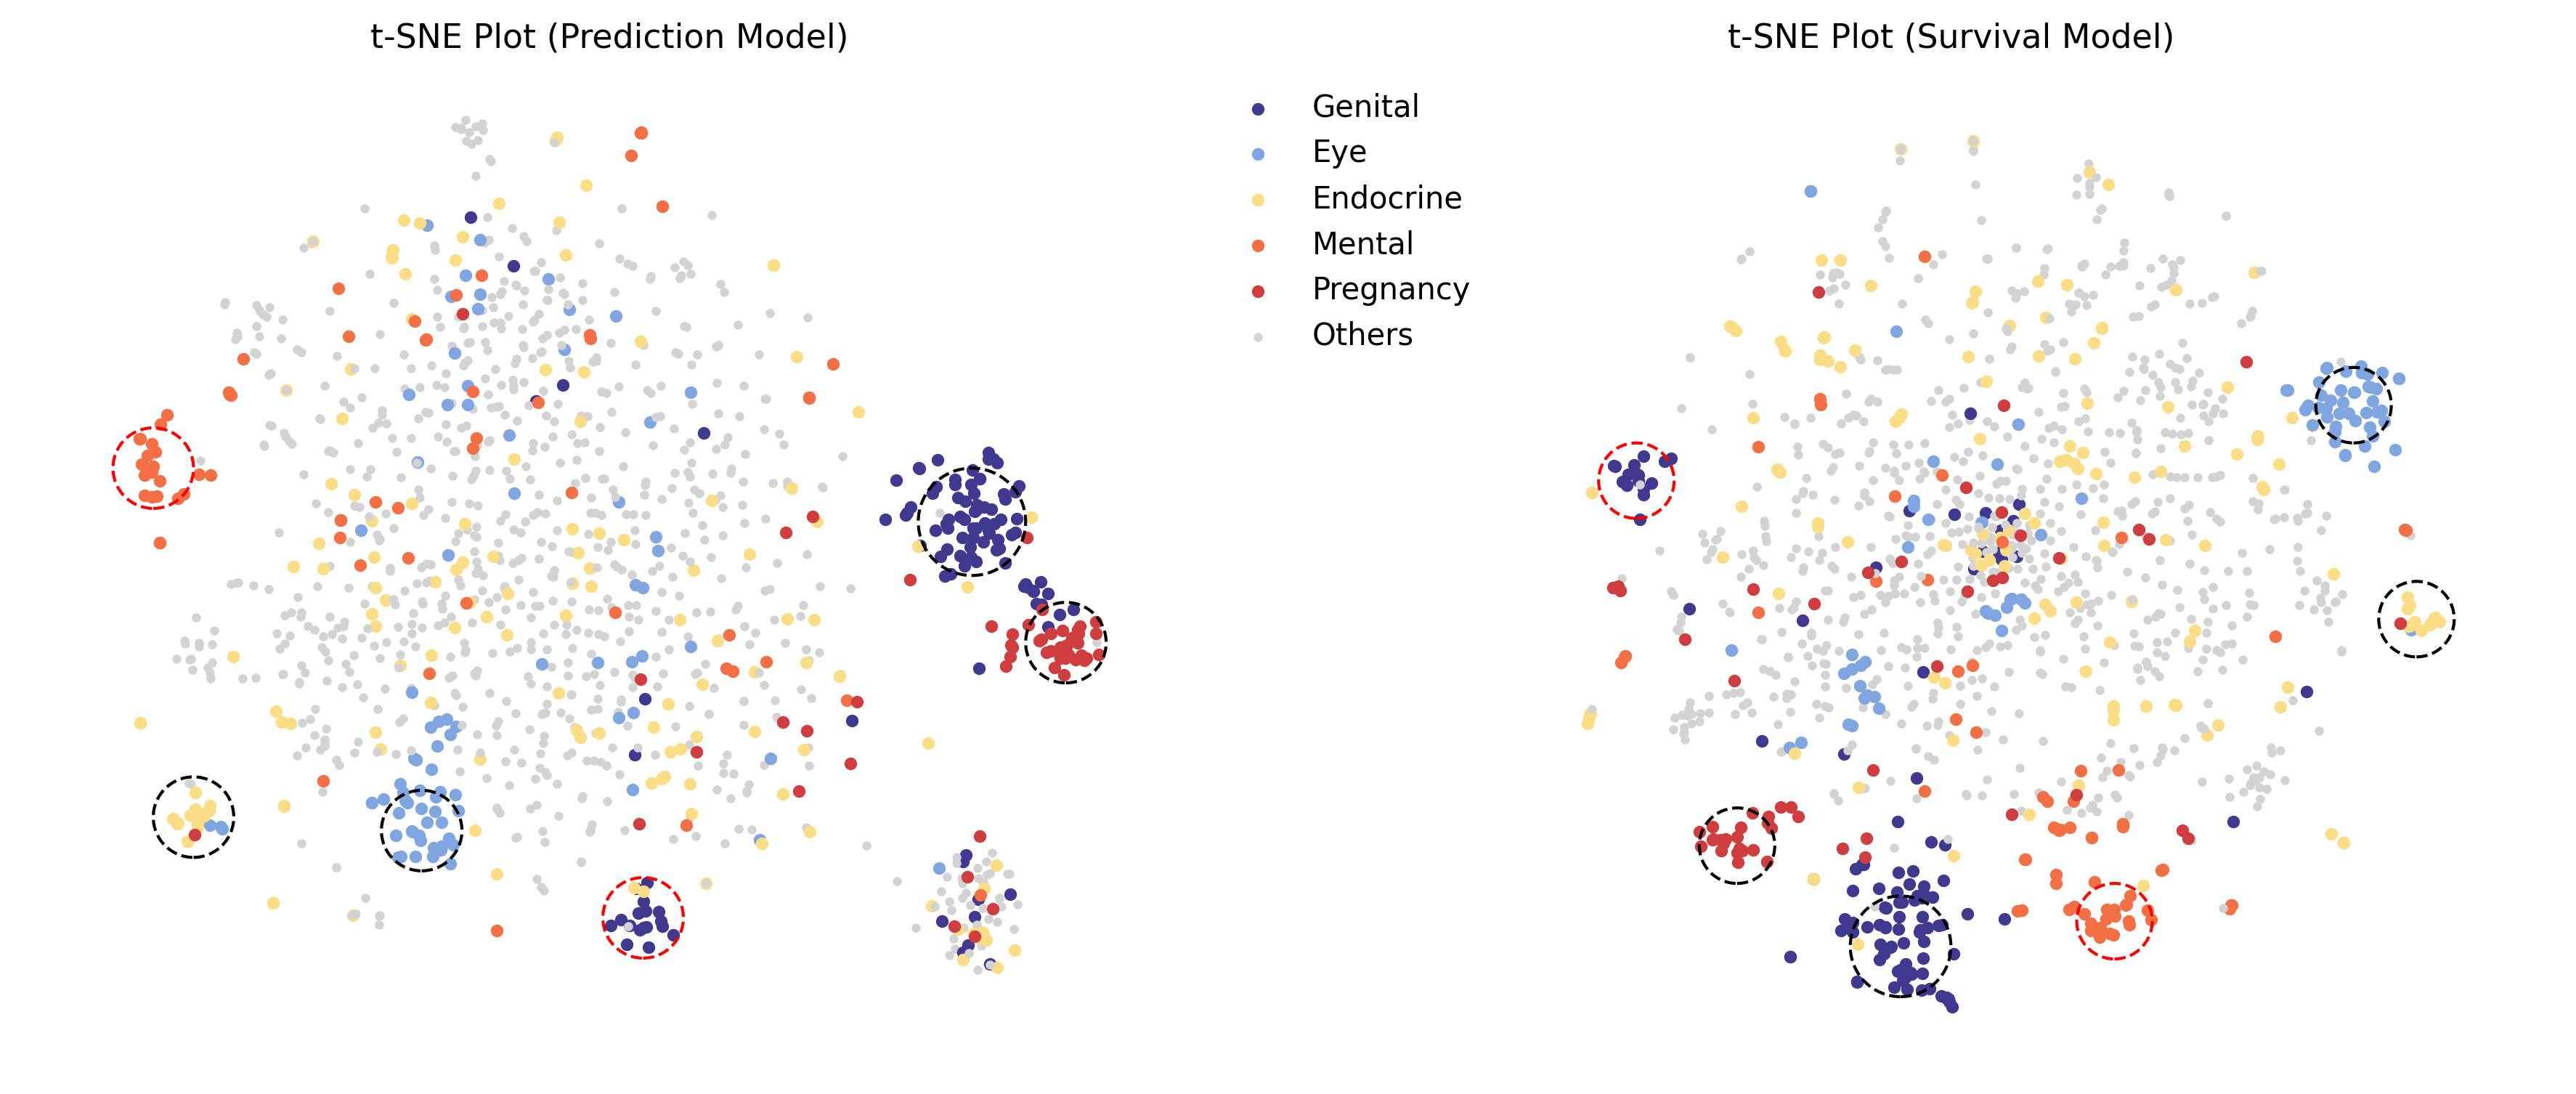

In [9]:
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=5)
fig = plt.figure(figsize=(15, 6), dpi=300)
gs0 = gridspec.GridSpec(1, 4, figure=fig, wspace=-0.3, width_ratios = [0.05,0.95,1.05,0.01])
ax0 = fig.add_subplot(gs0[0, 0])
ax0.axis('off')
ax1 = fig.add_subplot(gs0[0, 1])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_prediction[v,:]
    marker='o'
    if k in ['Genital', 'Pregnancy', 'Eye', 'Mental', 'Endocrine']:
        pic = ax1.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
        i+=1
    else:
        pic = ax1.scatter(x=temp[:, 0], y=temp[:, 1],s=4,color="#d3d3d3", label="Others") 
handles, labels = ax1.get_legend_handles_labels()
unique_legend_dict = {}
for handle, label in zip(handles, labels):
    if label == 'Others':
        continue
    if label not in unique_legend_dict:
        unique_legend_dict[label] = handle

unique_labels = list(unique_legend_dict.keys())
unique_handles = [unique_legend_dict[label] for label in unique_labels]
index = labels.index("Others")
unique_handles.append(handles[index])
unique_labels.append(labels[index])
title1 = 't-SNE Plot (Prediction Model)'
ax1.set_title(title1, fontsize=11)
# plot circles
c = plt.Circle((6.5,-25.5),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((-30,8),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((-27,-18),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((31,4),4, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((-10,-19),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
c = plt.Circle((38,-5),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax1.add_patch(c)
ax1.axis('off')
ax1.set_aspect('equal')
ax1.set_xlim(-37,45)
ax1.set_ylim(-37,38)

ax2 = fig.add_subplot(gs0[0, 2])
i=0 
legend_elements = []
for k,v in phecat.items():
    temp=X_tsne_survival[v,:]
    marker='o'
    if k in ['Genital', 'Pregnancy', 'Eye', 'Mental', 'Endocrine']:
        pic = ax2.scatter(x=temp[:, 0], y=temp[:, 1],s=10,color=cm(i), label=k) 
        i+=1
    else:
        pic = ax2.scatter(x=temp[:, 0], y=temp[:, 1],s=4,color="#d3d3d3", label="Others") 
title2 = 't-SNE Plot (Survival Model)'
ax2.set_title(title2, fontsize=11)
c = plt.Circle((-30,7),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((8,-28),3, edgecolor='red', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((32,-4),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((-9,-30),4, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((27,13),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
c = plt.Circle((-22,-22),3, edgecolor='black', fill=False, linewidth=1, linestyle='--')
ax2.add_patch(c)
ax2.axis('off')
ax2.set_xlim(-50,40)
ax2.set_ylim(-40,40)
ax2.set_aspect('equal')
legend = ax2.legend(unique_handles, unique_labels, bbox_to_anchor=(0.1, 1), fontsize=10)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
title = 't-SNE Plot'
ax3 = fig.add_subplot(gs0[0, 3])
ax3.axis('off')
plt.savefig(temppath+title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()